## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  
a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
#probabilty of converting = no. of converted / no of data frame indeces 
len(df.query('converted == 1')) / len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
query_treat_old=df.query('group == "treatment" & landing_page == "old_page"')
query_control_new=df.query('group == "control" & landing_page == "new_page"')

In [8]:
treatment_old_nu =len(query_treat_old) 
treatment_new_nu =len(query_control_new)

In [9]:
Missalinment_nu = treatment_old_nu+treatment_new_nu
Missalinment_nu

3893

f. Do any of the rows have missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


- there are no missing values as all have same number of indeces = 294478

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
# df2 from df where we excluded the 3893 records where new_page and treatment didn't line up
df2 = df.drop((query_treat_old.index) | (query_control_new.index))
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


- Now excluded 3893 records where new_page and treatment didn't line up

In [12]:
# Double Check all of the correct rows were removed - this should be 0
query_treat_old_df2=df2.query('group == "treatment" & landing_page == "old_page"')
query_control_new_df2=df2.query('group == "control" & landing_page == "new_page"')

In [13]:
query_treat_old_df2

,user_id,timestamp,group,landing_page,converted


In [14]:
query_control_new_df2

,user_id,timestamp,group,landing_page,converted


- As obvious the correct rows were removed

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [15]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

- Number of indeces is 290585 as in timestamp but user id HAS A DUPLICATE 

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
# as we see there's one dubplicate of index 1899 & 2893
df2["is_duplicate"]= df2.duplicated(subset= 'user_id')

c. What is the row information for the repeat **user_id**? 

In [17]:
df2[(df2.is_duplicate == True)]

,user_id,timestamp,group,landing_page,converted,is_duplicate
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [18]:
# droping row of index 2893 which is duplicated
df2.drop(2893, inplace=True)

In [19]:
# after deleted row
df2.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
is_duplicate         1
dtype: int64

- now it's FINE

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
# length of converted over len of df2
converted = len(df2.query('converted == 1'))/len(df2)
converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
#same as above
control_converted  = len(df2.query('group == "control" & converted == 1')) / len(df2.query('group == "control"'))
control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
#same as above
treatment_converted =  len(df2.query('group == "treatment" & converted == 1')) / len(df2.query('group == "treatment"'))
treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [23]:
#same as above
new_page = len(df2.query('landing_page == "new_page"'))/len(df2)
new_page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

In [24]:
## new treatment page conversions = treatment_converted
## then: 
diff = treatment_converted - control_converted
abs(diff)

0.0015782389853555567

- 0.0015 = 15 percent and this is little number to have sufficient evidence to say that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null hypothesis means the conversion rate of the old_page is greater or the same than the conversion rate of the newpage.        
Alternative hypothesis means the conversion rate of the old_page is less than the conversion rate of the newpage.

Hypothesis
$H_{0}$ : $p_{new}$ <= $p_{old}$,
$H_{1}$ : $p_{new}$ > $p_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [25]:
p_new = len(df2.query('converted == 1'))/len(df2)
p_new 

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [26]:
p_old = len(df2.query('converted == 1'))/len(df2)
p_old

0.11959708724499628

p_new = P_old then we will call them p_null 

In [27]:
p_null = p_new
p_null

0.11959708724499628

c. What is $n_{new}$?

In [28]:
n_new =len(df2.query('landing_page == "new_page"'))
n_new

145310

d. What is $n_{old}$?

In [29]:
n_old= len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [30]:
#numpy.random.choice(1 or 0 , size=size, , p=p_new) ::::
#Generates a random sample from a given 1-D array  ::::
#p function is 1-D array-like so we made it like (p_new, 1 - p_new) where p_new for 1 and (1 - p_new) for 0
new_page_converted = np.random.choice([1,0], size = n_new , p = (p_new, 1 - p_new))
new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [31]:
#numpy.random.choice(1 or 0 , size=size, , p=p_old) ::::
#Generates a random sample from a given 1-D array  ::::
#p function is 1-D array-like so we made it like (p_old, 1 - p_old) where p_old for 1 and (1 - p_old) for 0
old_page_converted = np.random.choice([1,0], size = n_old , p = (p_old, 1 - p_old))
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [32]:
# sum is to sum the ones so we find the value counts then devide by total length so we know the req. p .
p_diff = sum(new_page_converted)/n_new-sum(old_page_converted)/n_old
p_diff

-0.0007937366449898425

In [33]:
diff_percent =abs(p_diff)* 100
diff_percent

0.07937366449898425

- you must know also that we accept Null Hypothesis till the we find that the alternative is true .
- like : the charged is innocent till his guilty is proved

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

- here we initialize p_diffs empty array 
- then in every for loop iteration we compute [new_page_converted , old_page_converted] as in [e. , f.]
- then we calculate the difference between there means in every iteration then we have 10,000 $p_{new}$ - $p_{old}$
- fundtion ::::
- p_diffs=[]
- for i in range(10000) :
    - new_page_converted = np.random.choice([1,0], size = n_new , p = (p_new, 1 - p_new))
    - old_page_converted = np.random.choice([1,0], size = n_old , p = (p_old, 1 - p_old))
    - p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [34]:
# please not that the above function take long run time but it's CORRECT 
# if any troubles please press kernel then press restart and run all and thanks
# I kept it as a markdown for reviewing but will stimulate another function to run faster 

Text(0.5, 1.0, 'Simulated 10000 new_page Binomial distribution')

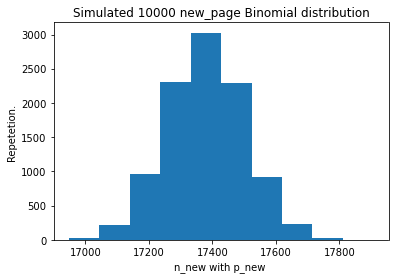

In [35]:
# we initialize binomial distribution for 10000 p_new
plt.hist(np.random.binomial(n_new,p_new,10000))
# where numpy.random.binomial(size , p probability of success where n an integer >= 0 and p is in the interval [0,1], size)
# result of p_new, n_new times, tested 10000 times.
plt.xlabel('n_new with p_new ')
plt.ylabel('Repetetion.')
plt.title('Simulated 10000 new_page Binomial distribution')

In [36]:
# so we will use next function : 
# after taking random samples and normalizing the values to probability by dividing with size of respective population
# we used Numpy arrays cause it's better than for loop cause of very little tie consumbtion of Numpy arrays 
p_diffs = []
new_page_converted = np.random.binomial(n_new,p_null,10000)
old_page_converted = np.random.binomial(n_old,p_null,10000)   
p_diffs = new_page_converted/n_new - old_page_converted/n_old
p_diffs = np.array(p_diffs)
# we calculated mean before difference because here n_new - n_old != zero , so difference will give error 

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

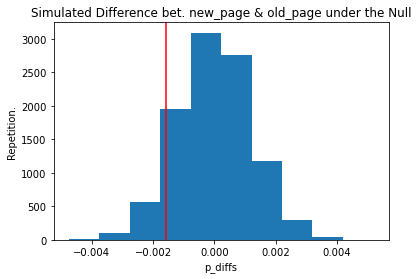

In [37]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Repetition.')
plt.title('Simulated Difference bet. new_page & old_page under the Null')
plt.axvline(x=diff, color = 'red'); # as Impact of Sample Size quize in class notebook;

- this red line represents the diff value computed in part one according to the data .

- block is as I expected , and yes I checked coin promblems in classroom to make sure to understand the meaning.
- original diff value equal -0.0015 so it's on left side of the plot.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [38]:
# Using diff = treatment_converted - control_converted calculated in part 1 to compare with calculated p_diffs.
p_diffs_greater_than_diff= (diff < p_diffs).mean()
p_diffs_greater_than_diff

0.908

In [39]:
# so p_diffs > diff (where diff = 15 %)
# with portion 0.9087

In [40]:
p_diffs_greater_than_diff_percent = p_diffs_greater_than_diff*100
p_diffs_greater_than_diff_percent

90.8

then 90.8699% is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv.

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- The value above represents the p-value while Null hypothesis is true.
- scientific studies of p_value as mentioned in classroom means probability of observing our statistic to judje if Null is True or False.
- we would fail to reject the Null hypothesis as p value is high = 0.9087 .
- It means almost no differences between the new and old pages so we keep old page as alternative hypthesis of new page is better is FALSE.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [41]:
old_page_converted = df2.query('landing_page == "old_page" & converted == 1')
nu_old_page_converted = len(old_page_converted)
new_page_converted = df2.query('landing_page == "new_page" & converted == 1')
nu_new_page_converted = len(new_page_converted)
old_page_user = df2.query('landing_page == "old_page"')
nu_old_page_user = len(old_page_user) 
new_page_user = df2.query('landing_page == "new_page"')
nu_new_page_user = len(new_page_user)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [42]:
#link wasn't working but this one was helpful
#https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
#alternative='smaller' because alternative hypothesis is proportion < p_diffs.
import statsmodels.api as sm
ztest_score , p_value = sm.stats.proportions_ztest([nu_old_page_converted, nu_new_page_converted],
                                              [nu_old_page_user, nu_new_page_user],
                                              alternative='smaller')

ztest_score , p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [43]:
from scipy.stats import norm
#calculate the critical ztest_critical_value where 1-(0.05) is 1-(significance level)
ztest_critical_value=norm.ppf(1-(0.05))
ztest_critical_value

1.6448536269514722

- ztest_score is less than ztest_critical_value  where 1.31 < 1.644
- the P_value > 5% where 5% is the significane 
- so we fail to reject the null hypothesis
- it goes on with the findings in j. and k. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

logistic regression as the variable is a binary variable (0,1).

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [44]:
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [60]:
#create a column for the intercept
df2['intercept'] = 1
#create a dummy variable
df2[['control','treatment']]= pd.get_dummies(df2['group']) 
#ab_page column
df2 = df2.rename( columns = {'treatment':'ab_page'})
df2.head(3)

,country,timestamp,group,landing_page,converted,is_duplicate,intercept,control,ab_page,US,CA,UK,ab_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,False,1,1,0,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,False,1,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,False,1,0,1,0,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [46]:
#Logit() function for performing logistic regression.
#Statsmodels is a Python module which provides various functions for estimating different statistical models 
#and performing statistical tests.
#Statsmodels provides a Logit() function for performing logistic regression.
#Builiding the Logistic Regression model:
import statsmodels.api as sm
log_reg = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
#The model is then fitted to the data.
log_reg = log_reg.fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        17:52:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

- p-value part III = 0.190 
- p-value part II = 0.905
- Null Hypothesis in part I 
$H_{0}$ : $p_{new}$ <= $p_{old}$,
$H_{1}$ : $p_{new}$ > $p_{old}$.
- Null Hypothesis in part III
$H_{0}$ : $p_{new}$ = $p_{old}$,
$H_{1}$ : $p_{new}$ != $p_{old}$.
- as mentioned by the reviewer the value differs from the value I found in part II because part III is two sided (two-tailed) test and Part II is a one sided test (one-tailed).

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

We could consider introducing the timestamp or Maybe Age of user if available to determine in which part of the day the individuals converted the most or if age contributes in converting if age is available. For example, if we find that the evening is the period that users spend most of their time on the internet we might also take it into consideration or maybe we find that young users always convert and get updated and old users keep using old and against any change MAYBE .

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
#DataFrame.join : Joins columns of another DataFrame.
countries_df = pd.read_csv('./countries.csv')
df2 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df2.head()

,country,timestamp,group,landing_page,converted,is_duplicate,intercept,control,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,False,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,False,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,False,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,False,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,False,1,0,1


In [49]:
df2['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [50]:
### necessary dummy variables
### the two coulumns will be US & CA, as UK won't be necessary as it doesn't represent max or min.
df2[['US','CA']]= pd.get_dummies(df2['country'])[['US','CA']]

In [51]:
df2.head()

,country,timestamp,group,landing_page,converted,is_duplicate,intercept,control,ab_page,US,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,False,1,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,False,1,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,False,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,False,1,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,False,1,0,1,0,0


In [61]:
###Linear Model And Obtain the Results
log_mod = sm.Logit(df2['converted'], df2[['CA', 'US', 'intercept','ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 05 Jan 2021   Pseudo R-squ.:               2.323e-05
Time:                        18:33:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0075   3.51e+05  -2.13e-08      1.000   -6.88e+05    6.88e+05
ab_page       -0.0075   3.51e+05  -2.13e-08      1.000   -6.88e+05    6.88e+05
==============================================================================
"""

- CA US P_values 0.074 , 0.456 still less than 0.0.5 ..

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

- countries have no impact on convergence. 
- CA was really close to accept the ALTERNATIVE hypothesis, as 0.074 (p_value of CA) almost near 0.05.

<a id='conclusions'></a>
## Conclusions
- At conlusion we can see that the old page was better than the new page, therefore I fail to refuse the null hypothesis, this is based on the probability figures, A/B testand regression.
- There is no strong evidence that the countries (US, CA and UK) influence the conversion rate. as the P-Value of countries didn't pass 0.5 and we can see that CA was really close to accept the ALTERNATIVE hypothesis.
- So the best to develop is to focus on another new landing page.
- And from the regression above we see that the p-value is higher in US than in Canada, which means that users in the Canada are more likely to convert, but still not enough evidence to reject the null hypothesis.

## References
- http://blog.analytics-toolkit.com/2017/statistical-significance-ab-testing-complete-guide/
- https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
- https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa
- https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/
- https://statistics.laerd.com/statistical-guides/standard-score.php https://www.geeksforgeeks.org/logistic--  - regression-using-statsmodels/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html

In [56]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1

## ALL THANKS